<a href="https://www.kaggle.com/code/ankitkumar2635/sentiment-and-emotion-classification-of-tweets?scriptVersionId=133713500" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Introduction 
In this notebook we explore the tweets mentioning **@Dell** and run a **sentiment analysis** and **emotions classification** using **HuggingFace's 🤗 transformers** to figure out the positives and negatives of the company's product and services. 


* The sentiment classifier labels the tweets as either positive, negative and neutral
* The emotion classifier classifies the tweets into 11 emotions: joy, love, optimism, pessimism, trust, surprise, anticipation, sadness, anger, disgust and fear. 
    

In this notebook, I have used a trasformer model ([cardiffnlp/twitter-roberta-base-sentiment-latest](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest)) to classify sentiment and we go a step deeper and classify emotions of the tweets using another transformer model ([cardiffnlp/twitter-roberta-base-emotion-multilabel-latest](https://huggingface.co/cardiffnlp/twitter-roberta-base-emotion-multilabel-latest)).  


**Data:** 

* [Dell Tweets 2022](https://www.kaggle.com/datasets/ankitkumar2635/dell-tweets-2022) which contains about 25k tweets from first three quarter of 2022

* The data has been collected from twitter using "snscrape". Follow this [notebook link](https://www.kaggle.com/code/ankitkumar2635/scrape-tweets-without-twitter-s-api) to learn more about scrapping tweets without Twitter's API.

* The data has four columns: 

   1. Datetime
   2. Tweet Id
   3. Text (the tweet)
   4. Username
   
   
#### Author: Ankit Kumar
#### Created on: 14/07/2023

# 1. Sentiment Classification Using Transformers

### Import required modules

In [1]:
pip install --upgrade accelerate #use it if you get import error for transformers' pipeline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 5.6 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.12.0
    Uninstalling accelerate-0.12.0:
      Successfully uninstalled accelerate-0.12.0
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from transformers import pipeline
import torch

from tqdm.notebook import tqdm # shows a progress bar on iterations 

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

### Load the tweets dataset

In [3]:
tweets_df = pd.read_csv("/kaggle/input/dell-tweets-2022/First three qtr Dell tweets.csv")
tweets_df.head()

,Datetime,Tweet Id,Text,Username
0,2022-09-30 23:29:15+00:00,1575991191170342912,@Logitech @apple @Google @Microsoft @Dell @Len...,ManjuSreedaran
1,2022-09-30 21:46:35+00:00,1575965354425131008,@MK_habit_addict @official_stier @MortalKombat...,MiKeMcDnet
2,2022-09-30 21:18:02+00:00,1575958171423752203,"As @CRN celebrates its 40th anniversary, Bob F...",jfollett
3,2022-09-30 20:05:24+00:00,1575939891485032450,@dell your customer service is horrible especi...,daveccarr
4,2022-09-30 20:03:17+00:00,1575939359160750080,@zacokalo @Dell @DellCares @Dell give the man ...,heycamella


In [4]:
tweets_df.shape

(24970, 4)

#### Lets read some random tweets

In [5]:
print(tweets_df.Text.values[3], "\n\n")
print(tweets_df.Text.values[38])

@dell your customer service is horrible especially agent syedfaisal who has made this experience of purchasing a new computer downright awful and I’ll reconsider ever buying a Dell in the future @DellTech 


@Dell @MichaelDell  u r known for the best in class laptop and hardware and even services. We are sure you will not disappoint. https://t.co/G7ECpgckwF


**These two tweets very well represent a negative and positive sentiment, respectively.**

#### Setting up the GPU

In [6]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

#### Define the sentiment classification model

In [7]:
model_path = "cardiffnlp/twitter-roberta-base-sentiment-latest"
s_classifier = pipeline("sentiment-analysis", model= model_path, tokenizer=model_path, device=1)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Xformers is not installed correctly. If you want to use memorry_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


#### Testing the model on a tweet

In [8]:
# keeping a tweet from the dataframe as example tweet
example = tweets_df.Text.values[44]
example

'@intel @Dell Slow clap for? Their laptops? Read some reviews first.'

**My understanding is: The user is making a sarcastic remark. Lets feed this tweet into the model**

In [9]:
s_classifier(example)

[{'label': 'negative', 'score': 0.7120250463485718}]

**The model did very well to recognise the sarcasm and labelled the sentiment as negative. Lets apply the model to entire dataset**

In [10]:
senti_res = {}
for i, row in tqdm(tweets_df.iterrows(), total = len(tweets_df)):
    text = row['Text']
    myid = row['Tweet Id']
    senti_res[myid] = s_classifier(text)

  0%|          | 0/24970 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1080: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


#### Merge the sentiment results to the original df

In [11]:
#Keeping the results as dataframe
sentiment_res = pd.DataFrame(senti_res).T
sentiment_res.head(5)

,0
1575991191170342912,"{'label': 'neutral', 'score': 0.8532827496528625}"
1575965354425131008,"{'label': 'neutral', 'score': 0.519469678401947}"
1575958171423752203,"{'label': 'positive', 'score': 0.7637905478477..."
1575939891485032450,"{'label': 'negative', 'score': 0.9540228843688..."
1575939359160750080,"{'label': 'neutral', 'score': 0.5291697978973389}"


In [12]:
# Split the dictionary col
sentiment_res= sentiment_res[0].apply(pd.Series)
sentiment_res.head(5)

,label,score
1575991191170342912,neutral,0.853283
1575965354425131008,neutral,0.519470
1575958171423752203,positive,0.763791
1575939891485032450,negative,0.954023
1575939359160750080,neutral,0.529170


In [13]:
# Rename index to Tweet Id, label to emotion
sentiment_res = sentiment_res.reset_index().rename(columns={'index': 'Tweet Id', 'label':'sentiment', 'score':'sentiment_score'})
sentiment_res.head(5)

,Tweet Id,sentiment,sentiment_score
0,1575991191170342912,neutral,0.853283
1,1575965354425131008,neutral,0.519470
2,1575958171423752203,positive,0.763791
3,1575939891485032450,negative,0.954023
4,1575939359160750080,neutral,0.529170


In [14]:
# merge to original df
tweets_df = tweets_df.merge(sentiment_res, how = "left")
tweets_df.head(5)

,Datetime,Tweet Id,Text,Username,sentiment,sentiment_score
0,2022-09-30 23:29:15+00:00,1575991191170342912,@Logitech @apple @Google @Microsoft @Dell @Len...,ManjuSreedaran,neutral,0.853283
1,2022-09-30 21:46:35+00:00,1575965354425131008,@MK_habit_addict @official_stier @MortalKombat...,MiKeMcDnet,neutral,0.519470
2,2022-09-30 21:18:02+00:00,1575958171423752203,"As @CRN celebrates its 40th anniversary, Bob F...",jfollett,positive,0.763791
3,2022-09-30 20:05:24+00:00,1575939891485032450,@dell your customer service is horrible especi...,daveccarr,negative,0.954023
4,2022-09-30 20:03:17+00:00,1575939359160750080,@zacokalo @Dell @DellCares @Dell give the man ...,heycamella,neutral,0.529170


<Axes: title={'center': 'Count of Sentiments'}>

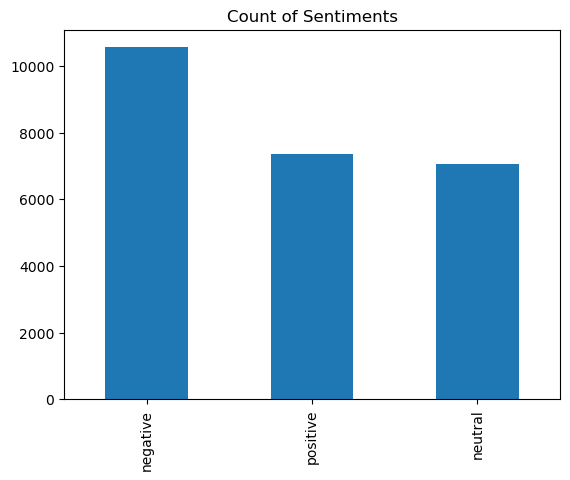

In [15]:
tweets_df.sentiment.value_counts().plot(kind='bar', title = "Count of Sentiments")

# 2. Emotion Classification Using Transformers 

#### Define the emotion classifier model

In [16]:
e_classifier = pipeline("text-classification", model="cardiffnlp/twitter-roberta-base-emotion-multilabel-latest", return_all_scores=False, device=0)

/opt/conda/lib/python3.10/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [17]:
example

'@intel @Dell Slow clap for? Their laptops? Read some reviews first.'

In [18]:
# Testing the model on example
e_classifier(example)

[{'label': 'disgust', 'score': 0.616306483745575}]

**Now I am surprised by the performance of these models. Lets apply this model to our entire dataset** 

In [19]:
emotion_res = {}
for i, row in tqdm(tweets_df.iterrows(), total = len(tweets_df)):
    text = row['Text']
    myid = row['Tweet Id']
    emotion_res[myid] = e_classifier(text)

  0%|          | 0/24970 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1080: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


#### Merge the results to original data

In [20]:
# Similar steps to sentiment classification
emotions_res = pd.DataFrame(emotion_res).T
emotions_res= emotions_res[0].apply(pd.Series)
emotions_res = emotions_res.reset_index().rename(columns={'index': 'Tweet Id', 'label':'emotion', 'score':'emotion_score'})
tweets_df = tweets_df.merge(emotions_res, how = "left")
tweets_df.head(5)

,Datetime,Tweet Id,Text,Username,sentiment,sentiment_score,emotion,emotion_score
0,2022-09-30 23:29:15+00:00,1575991191170342912,@Logitech @apple @Google @Microsoft @Dell @Len...,ManjuSreedaran,neutral,0.853283,anticipation,0.587121
1,2022-09-30 21:46:35+00:00,1575965354425131008,@MK_habit_addict @official_stier @MortalKombat...,MiKeMcDnet,neutral,0.519470,joy,0.886913
2,2022-09-30 21:18:02+00:00,1575958171423752203,"As @CRN celebrates its 40th anniversary, Bob F...",jfollett,positive,0.763791,joy,0.960347
3,2022-09-30 20:05:24+00:00,1575939891485032450,@dell your customer service is horrible especi...,daveccarr,negative,0.954023,anger,0.983203
4,2022-09-30 20:03:17+00:00,1575939359160750080,@zacokalo @Dell @DellCares @Dell give the man ...,heycamella,neutral,0.529170,anger,0.776124


<Axes: title={'center': 'Count of Emotions'}>

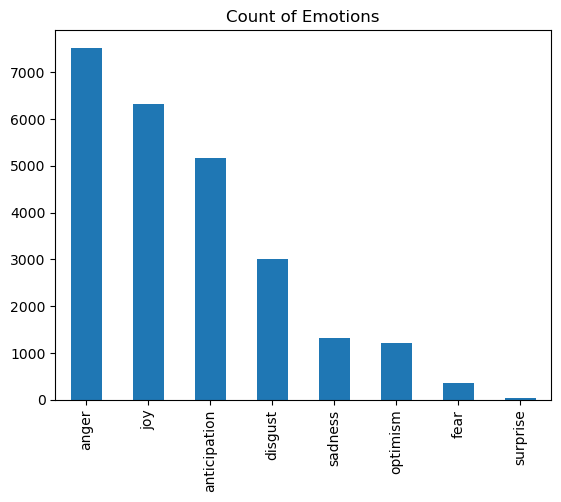

In [21]:
tweets_df['emotion'].value_counts().plot(kind='bar', title ='Count of Emotions')

In [22]:
# save the df as output
tweets_df.to_csv('sentiment-emotion-labelled_Dell_tweets')

# 3. EDA on Sentiment and Emotion Labelled Dataset

### Visualise emotions for different sentiments of tweets

I want to see how the emotions look for tweets which are labelled as positive

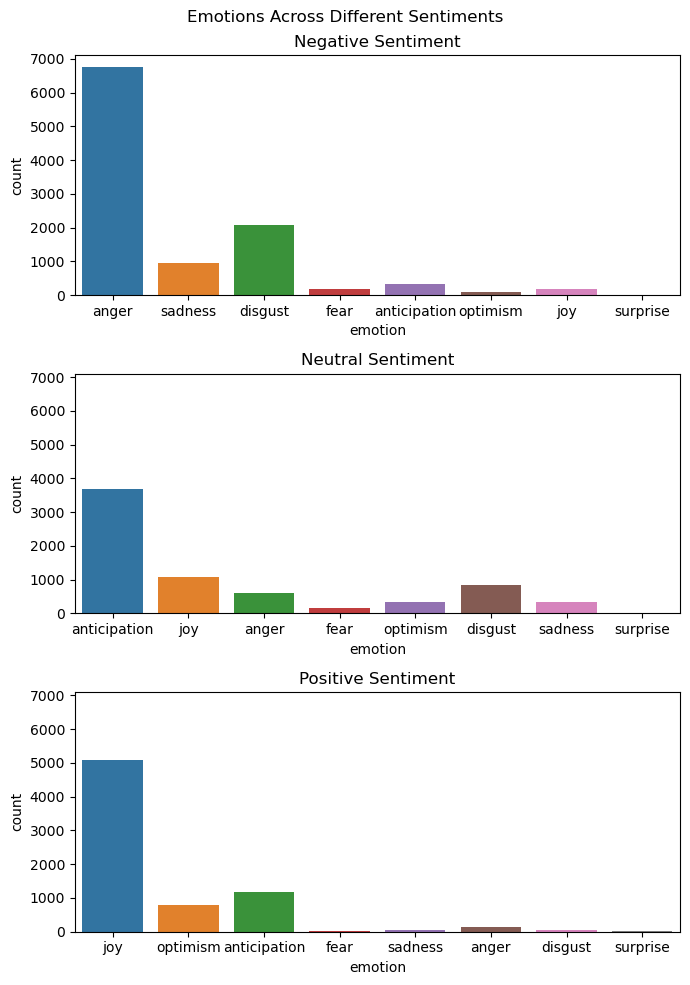

In [23]:
fig, axes = plt.subplots(3,1, figsize = (7,10), sharey = True)
plt.suptitle('Emotions Across Different Sentiments')
sns.countplot(data=tweets_df.loc[tweets_df.sentiment == 'negative'], x= 'emotion', ax= axes[0])
axes[0]. title. set_text("Negative Sentiment")
sns.countplot(data=tweets_df.loc[tweets_df.sentiment == 'neutral'], x= 'emotion', ax= axes[1])
axes[1]. title. set_text("Neutral Sentiment")
sns.countplot(data=tweets_df.loc[tweets_df.sentiment == 'positive'], x= 'emotion', ax= axes[2])
axes[2]. title. set_text("Positive Sentiment")
plt.tight_layout()

### Examine sentiments and emotions across financial quarters (Q1 to Q3)

In [24]:
# Break df into three quaters 
Q1_tweets = tweets_df.loc[tweets_df.Datetime < '2022-04-01']
Q2_tweets = tweets_df.loc[tweets_df.Datetime < '2022-07-01']
Q3_tweets = tweets_df.loc[tweets_df.Datetime >= '2022-07-01']

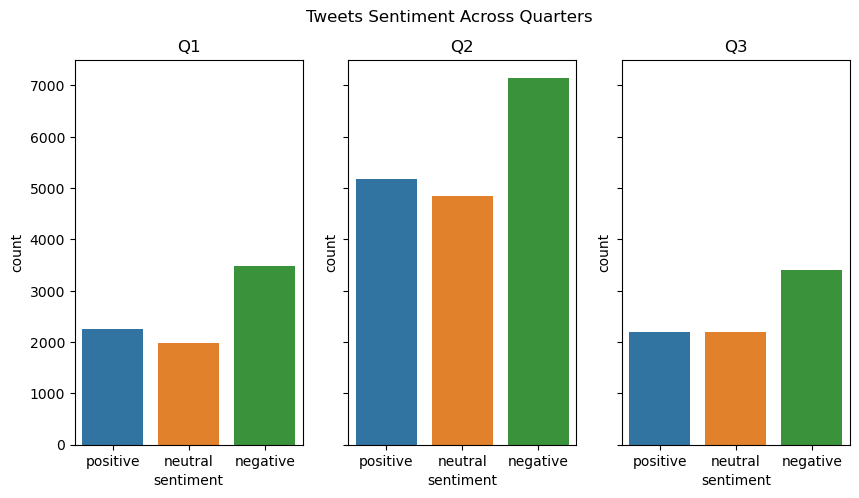

In [25]:
fig, axes = plt.subplots(1,3, figsize = (10,5), sharey = True)
plt.suptitle("Tweets Sentiment Across Quarters")
sns.countplot(data=Q1_tweets, x='sentiment', ax=axes[0], order=['positive', 'neutral', 'negative'])
axes[0]. title. set_text("Q1")
sns.countplot(data=Q2_tweets, x='sentiment', ax=axes[1], order=['positive', 'neutral', 'negative'])
axes[1]. title. set_text("Q2")
sns.countplot(data=Q3_tweets, x='sentiment', ax=axes[2], order=['positive', 'neutral', 'negative'])
axes[2]. title. set_text("Q3")

* Negative tweets are higher across all the quarters
* Total number of tweets spiked during the second quarter

### Visualise emotions across quarters 

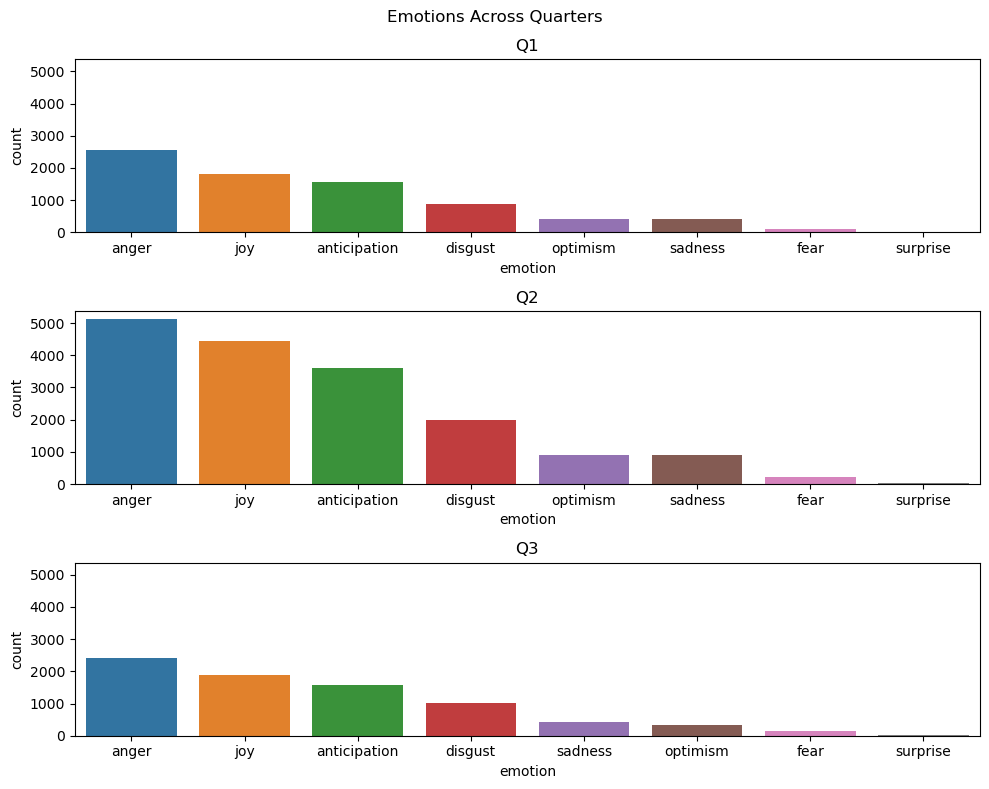

In [26]:
fig, axes = plt.subplots(3,1, figsize = (10,8), sharey = True)
plt.suptitle("Emotions Across Quarters")
sns.countplot(data=Q1_tweets, x='emotion', ax=axes[0], order=Q1_tweets['emotion'].value_counts().index)
axes[0]. title. set_text("Q1")
sns.countplot(data=Q2_tweets, x='emotion', ax=axes[1], order=Q2_tweets['emotion'].value_counts().index )
axes[1]. title. set_text("Q2")
sns.countplot(data=Q3_tweets, x='emotion', ax=axes[2], order=Q3_tweets['emotion'].value_counts().index)
axes[2]. title. set_text("Q3")
plt.tight_layout()

As expected: 'anger' dominates the show, as most of the tweets show negative sentiment. So here is a human behavioral lesson:

People respond more to negative stimuli, thats called negative bias.

For example: How often you read or say "My laptop's fan has got too noisy", but we hardly mention it when it is working as it should. Got my point!

### Create a wordcloud of negative tweets each quarter 

In [27]:
from wordcloud import WordCloud, STOPWORDS

In [28]:
# Combine quarterly negative tweets into a single text
Q1_neg_text =  ''.join(Q1_tweets.loc[Q1_tweets.sentiment == 'negative'].Text)
print("There are {} words in the combination of Q1 negative tweets.\n" .format(len(Q1_neg_text)))

Q2_neg_text =  ''.join(Q2_tweets.loc[Q2_tweets.sentiment == 'negative'].Text)
print("There are {} words in the combination of Q2 negative tweets.\n" .format(len(Q2_neg_text)))

Q3_neg_text =  ''.join(Q3_tweets.loc[Q3_tweets.sentiment == 'negative'].Text)
print("There are {} words in the combination of Q3 negative tweets.\n" .format(len(Q3_neg_text)))

There are 634651 words in the combination of Q1 negative tweets.

There are 1311236 words in the combination of Q2 negative tweets.

There are 652026 words in the combination of Q3 negative tweets.



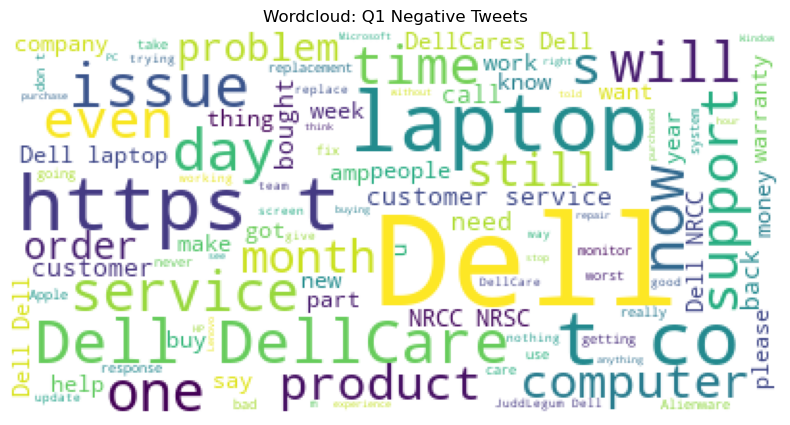

In [29]:
# Create word cloud of negative tweets for Q1
stopwords = set(STOPWORDS)
word_cloud = WordCloud(background_color = 'white', 
                       stopwords = stopwords, 
                       max_words = 100).generate(Q1_neg_text)


plt.figure(figsize = (8, 8))
plt.imshow(word_cloud)
plt.axis("off")
plt.title('Wordcloud: Q1 Negative Tweets')
plt.tight_layout()
 
plt.show()

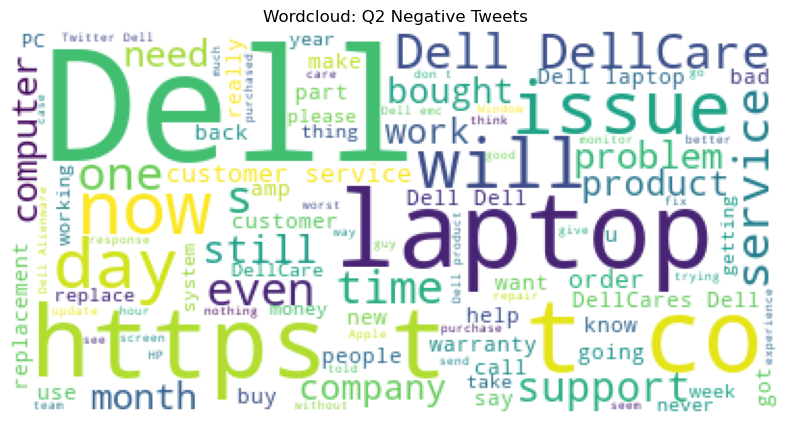

In [30]:
# Create word cloud of negative tweets for Q2
stopwords = set(STOPWORDS)
word_cloud = WordCloud(background_color = 'white', 
                       stopwords = stopwords, 
                       max_words = 100).generate(Q2_neg_text)

plt.figure(figsize = (8, 8))
plt.imshow(word_cloud)
plt.axis("off")
plt.title('Wordcloud: Q2 Negative Tweets')
plt.tight_layout()
 
plt.show()

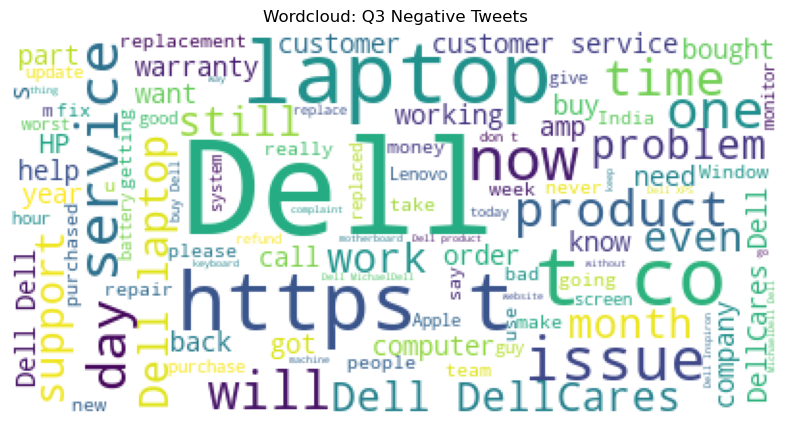

In [31]:
# Create word cloud of negative tweets for Q3
stopwords = set(STOPWORDS)
word_cloud = WordCloud(background_color = 'white', 
                       stopwords = stopwords, 
                       max_words = 100).generate(Q3_neg_text)

plt.figure(figsize = (8, 8))
plt.imshow(word_cloud)
plt.axis("off")
plt.title('Wordcloud: Q3 Negative Tweets')
plt.tight_layout()
 
plt.show()

**Few words pop out in each wordcloud: words like "Dell Care", "service", "warranty" and "customer service". So we figure out that most of "anger" is around Dell's customer service.**